# Hypothesis: 

## More accidents at football stadiums on days of football matches

In [11]:
from pathlib import Path
import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [42]:
# creating Path object for current working directory
cwd = Path('./')
root_dir = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root_dir / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directory
plots_dir = root_dir / 'plots'
# create new directory for plots directory
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = Path(root_dir / 'data')

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/home/jake/Documents/TrafficAccidents/data/vehicles2019.csv
/home/jake/Documents/TrafficAccidents/data/accidents2019.csv
/home/jake/Documents/TrafficAccidents/data/casualties2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location,district,converted_date,converted_time,datetime,decimal_time,day_of_year
0,2019010152270,-0.127949,51.436208,1,3,2,1,3,9,E09000022,...,0,1,3,E01003117,lambeth,2019-01-15,21:45:00,2019-01-15 21:45:00,21.750000,15
1,2019010157567,-0.123427,51.449310,1,3,2,2,3,9,E09000022,...,0,1,1,E01003023,lambeth,2019-01-15,08:42:00,2019-01-15 08:42:00,8.700000,15
2,2019010157732,-0.145106,51.461256,1,2,1,2,3,9,E09000022,...,0,1,1,E01003026,lambeth,2019-01-15,07:08:00,2019-01-15 07:08:00,7.133333,15
3,2019010157896,-0.240823,51.533125,1,3,2,1,3,28,E09000005,...,0,1,1,E01000535,brent,2019-01-15,21:05:00,2019-01-15 21:05:00,21.083333,15
4,2019010157795,0.161736,51.550272,1,3,1,1,3,16,E09000002,...,0,1,1,E01000035,barking and dagenham,2019-01-15,16:10:00,2019-01-15 16:10:00,16.166667,15


In [13]:
def sphere_distance(s_lat, s_lng, e_lat, e_lng):
    R = 6373.0
    
    s_lat = s_lat*np.pi/180
    s_lng = np.deg2rad(s_lng)
    e_lat = np.deg2rad(e_lat)
    e_lng = np.deg2rad(e_lng)
    
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    
    return 2 * R * np.arcsin(np.sqrt(d))

### Test case:

First, a test case shall be run for a football match at Old Trafford football stadium on 24/02/2019

In [14]:
# coordinates for Old Trafford football stadium in Manchester
manc = [53.457831502, -2.288165514]

In [15]:
acc_manc = accidents

# create feature of the distance (in km) of an accident to Old Trafford
acc_manc['dist_from_manc'] = sphere_distance(manc[0], manc[1], acc_manc['latitude'], acc_manc['longitude'])

# filter for those accidents within 5km radius
distance_mask = acc_manc.dist_from_manc < 5
acc_manc = acc_manc[distance_mask]
# filter for Sunday
sunday_mask = acc_manc['day_of_week'] == 1
sunday_manc = acc_manc[sunday_mask]

# group by day and count number of accidents
sundays = sunday_manc.groupby('converted_date')['accident_index'].count()

zscores = stats.zscore(sundays)
zscores['2019-02-24']

sundays.mean()

1.7692307692307692

The value of accidents on the Sunday of the football match is 1.3 standard deviations away from the average. This deserves further investigation.

In [16]:
football = pd.read_csv(additional_data_dir / 'football_stats.csv')
football['datetime'] = pd.to_datetime(football['datetime'])
football['converted_date'] = football['datetime'].dt.date

acc_i = accidents.copy()
football = football.sort_values('day_of_year')
acc_i = acc_i.drop('datetime', axis=1)
football = football.drop('datetime', axis=1)

football.head(5)

,attendance,home_team_name,away_team_name,stadium_name,latitude,longitude,day_of_year,day_of_week,converted_date
0,39052,Everton,Leicester City,Goodison Park,53.4387,-2.966190,1,3,2019-01-01
18,32485,Cardiff City,Tottenham Hotspur,Cardiff City,51.4729,-3.204130,1,3,2019-01-01
9,59887,Arsenal,Fulham,Emirates,51.5549,-0.108436,1,3,2019-01-01
27,30666,Wolverhampton Wanderers,Crystal Palace,Molineux,52.5904,-2.130610,2,4,2019-01-02
36,40668,Chelsea,Southampton,Stamford Bridge,51.4816,-0.191034,2,4,2019-01-02


In [27]:
zscores_list = []
for i in range(football.shape[0]):
    
    coordinates = [football.loc[i, 'latitude'], football.loc[i,'longitude']]
    football_day = football.loc[i, 'day_of_year']
    football_day_of_week = football.loc[i, 'day_of_week']
    football_stadium = football.loc[i, 'stadium_name']
    
    acc_i = accidents.copy()
    
    # add distance from stadium as a feature
    acc_i['dist_from_stadium'] = sphere_distance(coordinates[0], coordinates[1],
                                                 acc_i['latitude'], acc_i['longitude'])

    # filter for those accidents within 5km radius of the stadium
    distance_mask = acc_i['dist_from_stadium'] < 10
    # filter for that day of the week
    day_of_week_mask = acc_i['day_of_week'] == football_day_of_week

    final = acc_i[distance_mask & day_of_week_mask]
    

    final = final.groupby('day_of_year')['accident_index'].count()
    
    zscores = stats.zscore(final)
    mean = final.mean()
    
    if football_day in zscores.index:
        zscore = zscores[football_day]
        accidents_on_day = final[football_day]
    else:
        zscore = 0
        accidents_on_day = 0
    
    info = {
        'Day of match': football_day,
        'Stadium': football_stadium,
        'Accidents on the day of match': accidents_on_day,
        'Mean # Accidents in area': mean,
        'z-score': zscore
    }
    
        
    zscores_list.append(info)

In [28]:
a = pd.DataFrame(zscores_list)
a.drop([])

,Day of match,Stadium,Accidents on the day of match,Mean # Accidents in area,z-score
0,1,Goodison Park,3,4.264151,-0.670671
1,13,Goodison Park,4,3.080000,0.665062
2,33,Goodison Park,1,3.230769,-1.274802
3,37,Goodison Park,3,4.211538,-0.676716
4,62,Goodison Park,3,3.080000,-0.057831
...,...,...,...,...,...
121,93,Tottenham Hotspur,18,17.538462,0.104265
122,103,Tottenham Hotspur,15,17.038462,-0.411199
123,113,Tottenham Hotspur,19,16.773585,0.514289
124,117,Tottenham Hotspur,14,17.038462,-0.612919


In [41]:
b = a.groupby('Stadium').mean()

b = b.drop('Day of match', axis=1)
b.iloc[:, :-1] = b.iloc[:, :-1].round(1)
b.iloc[:, -1] = b.iloc[:, -1].round(2)
b.columns = ['# Day of match', 'Avg # in area', 'z-score']


b.to_csv('test.csv')

In [32]:
a.describe()

,Day of match,Accidents on the day of match,Mean # Accidents in area,z-score
count,126.000000,126.000000,126.000000,126.000000
mean,70.317460,7.420635,7.982430,-0.057616
std,40.084241,7.609839,7.215750,0.817756
min,1.000000,0.000000,1.000000,-2.123445
25%,33.250000,2.000000,2.069183,-0.658984
50%,68.000000,4.000000,4.239919,0.000000
75%,108.750000,14.000000,14.548077,0.359493
max,132.000000,29.000000,24.653846,2.885372


In [18]:
stadium_coords = football.filter(['latitude', 'longitude'])

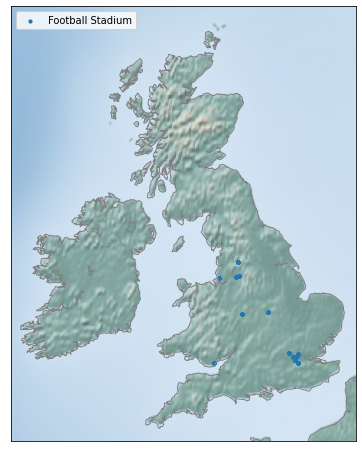

In [46]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(llcrnrlon=-10.5,llcrnrlat=49.5,urcrnrlon=3.5,urcrnrlat=59.5,
            resolution='i',projection='tmerc',lon_0=-4.36,lat_0=54.7)
m.shadedrelief()
m.drawcoastlines(color='grey')
m.drawcountries(color='gray')

m.scatter(stadium_coords.longitude, stadium_coords.latitude,
          latlon=True,
          alpha=1,
          s=10,
          marker='o',
          label='Football Stadium')

plt.legend(loc='upper left')

fig.savefig(plots_dir / 'stadiums')